# COGS 118A FINAL PROJECT

In this project I will be comparing the performance of 4 classifiers on 3 different datasets. <br>
The 4 classifiers I willl be training are: 
1. Logistic Regression Classifier 
2. Decision Tree Classifier 
3. Random Forest Classifier 
4. XGBoost Classifier <br>

The 3 datasets I will be working on are: 
1. Stroke Prediction Dataset (Kaggle): https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download
2. Clothing Fit Dataset for Size Recommendation (Kaggle): https://www.kaggle.com/datasets/rmisra/clothing-fit-dataset-for-size-recommendation
3. Telco Customer Churn (Kaggle): https://www.kaggle.com/datasets/blastchar/telco-customer-churn <br>

The evaluation metrics I will be using to compare performance are: 
1. Accuracy 
2. F-1 Score 
3. Precision 
4. Recall 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning, FitFailedWarning, ConvergenceWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)


## Helper Functions

### Cleaning the data 

In [4]:
def impute(df, method='median', val=None):
    """ Deal with missing entries in the DataFrame, and return the cleaned dataframe. """
    
    df = df.copy()

    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Compute imputation values if not provided
    if val is None:
        if method.lower().strip() == 'median':
            val = df[numeric_cols].median()
        elif method.lower().strip() == 'mean':
            val = df[numeric_cols].mean()
        elif method.lower().strip() == 'mode':
            val = df[numeric_cols].mode().iloc[0]
        else:
            raise ValueError("Invalid method. Use 'mean', 'median', or 'mode'.")

        # Fill **only numeric** columns
        df[numeric_cols] = df[numeric_cols].fillna(val)

        return df, val

    else:
        # Apply training numeric imputation values ONLY to numeric columns
        df[numeric_cols] = df[numeric_cols].fillna(val)
        return df


In [5]:
def missing_categoricals(df, cols, replace='Missing'):

    for column in cols:
        if column in cols:
            df[column] = df[column].fillna(replace)
        else:
            print("Column does not exist.")
            
    return df 

### Encoding Categorical Data

In [6]:
def encode_category(df, cols, encoder=None):
    """One-hot encode categorical columns. Fit on train, transform on test."""

    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        encoded = encoder.fit_transform(df[cols])
    else:
        encoded = encoder.transform(df[cols])

    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(cols),
        index=df.index
    )

    df_dropped = df.drop(cols, axis=1)

    df_encoded = pd.concat([df_dropped, encoded_df], axis=1)

    return df_encoded, encoder


### Standardizing numeric features 

In [7]:
def standardize_data(X, column_list=[], scaler=None):
    """ This function standardizes the relevant numeric features. """

    
    if scaler is None:
        scaler = StandardScaler()
        X[column_list] = scaler.fit_transform(X[column_list])
    else:
        X[column_list] = scaler.transform(X[column_list])

    return X, scaler

### Splitting data into train and test data

In [8]:
def split_data(X, y, test_size=0.2, random_state=42):
    """ This function splits the data into training and test sets. """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

### Gridsearch for best parameters, training model, and evaluations

In [9]:
def gridsearch_train(X_train, X_test, y_train, y_test, classifier, param_grid, cv=5, refit='f1'):
    """ 
    This function performs GridSearch to find the optimal set of parameters. 
    Then we train the classfier based on these optimal parameters.
    We then btain the evaluation metrics for the classifier. 
    """
    
    gs = GridSearchCV(estimator=classifier, param_grid=param_grid, 
                      scoring={'accuracy': 'accuracy', 'f1': 'f1','precision': 'precision', 'recall': 'recall'}, 
                      cv=cv, refit=refit, error_score=np.nan)
    gs.fit(X=X_train, y=y_train)
    
    best_estimator = gs.best_estimator_
    best_parameters = gs.best_params_

    y_pred = best_estimator.predict(X_test)

    eval_metrics = {
        'accuracy' : accuracy_score(y_test, y_pred),
        'f1_score' : f1_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred),
        'recall' : recall_score(y_test, y_pred)
    }

    return eval_metrics, best_estimator

### Function to get cross-validation results

In [10]:
def evaluate_with_cv(model, X, y, cv_splits=5):
    """
    Evaluate a trained model using cross-validation.
    Returns a DataFrame with scores for each fold and the average.
    """

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=False
    )

    # Return mean values in a clean dictionary
    cv_results = {
        'cv_mean_accuracy': float(np.mean(scores['test_accuracy'])),
        'cv_mean_precision': float(np.mean(scores['test_precision'])),
        'cv_mean_recall': float(np.mean(scores['test_recall'])),
        'cv_mean_f1': float(np.mean(scores['test_f1']))
    }

    return cv_results

## Plotting Metrics vs Training Size

In [148]:
import matplotlib.pyplot as plt

def plot_metrics_vs_training_size(train_sizes, accuracies, precisions, recalls, f1s, title="Performance vs. Training Set Size"):
    """ Plots accuracy, precision, recall, and F1-score as line plots against training set sizes. """

    plt.figure(figsize=(10, 6))

    plt.plot(train_sizes, accuracies, marker='o', label="Accuracy")
    plt.plot(train_sizes, precisions, marker='o', label="Precision")
    plt.plot(train_sizes, recalls, marker='o', label="Recall")
    plt.plot(train_sizes, f1s, marker='o', label="F1 Score")

    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.75))
    plt.tight_layout()
    plt.show()


### Defining Parameter Grids

In [11]:
# Since some solvers for the logistic regressor only work with some types of pentalties i.e. l1/l2/elasticnet,
# we define the parameters to be a list of dictionaries. 
parameters_log_reg = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'saga'],
        'C': [0.1, 1, 5],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.1, 1, 5],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.0, 0.5, 1.0],
        'C': [0.1, 1, 5],
        'class_weight': [None, 'balanced']
    }
]

In [12]:
# Parameter grid for support vector classifier. 
parameters_svc = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10],
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    }
]

In [13]:
# Parameter grid for decision tree. 
parameters_dt= [
    {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
    }
]

In [14]:
# Parameter grid for random forest. 
parameters_rf = [
    {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [1, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced']
    }
]

## Dataset 1: Stroke Prediction Dataset  

### Loading + EDA 

In [15]:
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(f"The shape of dataset1 is: {stroke_df.shape}.")
print("Preview of the dataset: ")
stroke_df.head()

The shape of dataset1 is: (5110, 12).
Preview of the dataset: 


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [16]:
stroke_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [18]:
# Drop the ID column since it is not a meangingful predictor. 
stroke_df.drop(columns=['id'], inplace=True)
print(f"The relevant columns we will use are: {list(stroke_df.columns)}")

The relevant columns we will use are: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [19]:
# Extracting features and predictors of the stroke dataset. 
stroke_X = stroke_df.iloc[:, : -1]
print(f"Features: {list(stroke_X.columns)}")
stroke_y = stroke_df.iloc[:, -1]
print(f"Target is the stroke prediction: 1/0")

Features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Target is the stroke prediction: 1/0


In [20]:
stroke_X_cat_cols = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married']

### 80/20 Split

In [21]:
# Spilt the dataset into training and test data. 
stroke_X_train_80, stroke_X_test_80, stroke_y_train_80, stroke_y_test_80 = split_data(stroke_X, stroke_y, test_size=0.2, random_state=42)
print(f"Shape of X_training : {stroke_X_train_80.shape}")
print(f"Shape of X_testing : {stroke_X_test_80.shape}")

Shape of X_training : (4088, 10)
Shape of X_testing : (1022, 10)


In [22]:
# Clean the trainging and test datasets. 
stroke_X_train_80, val = impute(stroke_X_train_80, method='median')
stroke_X_test_80 = impute(stroke_X_test_80, method='median', val=val)
# Fill in missing categorical entries.
stroke_X_train_80 = missing_categoricals(stroke_X_train_80, stroke_X_cat_cols, replace='Missing')
stroke_X_test_80 = missing_categoricals(stroke_X_test_80, stroke_X_cat_cols, replace='Missing')

print(stroke_X_test_80.isna().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


In [23]:
# Encode categorical features using OneHotEncoding.
stroke_X_train_80, encoder = encode_category(stroke_X_train_80, stroke_X_cat_cols)
stroke_X_test_80, ecoder2 = encode_category(stroke_X_test_80, stroke_X_cat_cols, encoder=encoder)

# Standardize numeric features.
stroke_X_train_80, sc = standardize_data(stroke_X_train_80, ['age', 'avg_glucose_level', 'bmi'])
stroke_X_test_80, sc2 = standardize_data(stroke_X_test_80, ['age', 'avg_glucose_level', 'bmi'], scaler=sc )

In [24]:
stroke_X_train_80.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'ever_married_No', 'ever_married_Yes'],
      dtype='object')

#### Logistic Regression

In [25]:
stroke_logreg_metrics_80, stroke_logreg_80_best = gridsearch_train(
    stroke_X_train_80, stroke_X_test_80, stroke_y_train_80, stroke_y_test_80, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

stroke_logreg_80_cv = evaluate_with_cv(stroke_logreg_80_best, stroke_X_train_80, stroke_y_train_80)

print(f"The best metrics achieved are: {stroke_logreg_metrics_80}")
print(f"The cross-validation results are: {stroke_logreg_80_cv}")

The best metrics achieved are: {'accuracy': 0.7446183953033269, 'f1_score': 0.2689075630252101, 'precision': 0.16271186440677965, 'recall': 0.7741935483870968}
The cross-validation results are: {'cv_mean_accuracy': 0.7358159286314951, 'cv_mean_precision': 0.12445127731805358, 'cv_mean_recall': 0.790896159317212, 'cv_mean_f1': 0.21503963485267766}


#### Support Vector Claasifier 

In [26]:
stroke_svc_metrics_80, stroke_svc_80_best = gridsearch_train(
    stroke_X_train_80, stroke_X_test_80, stroke_y_train_80, stroke_y_test_80, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

stroke_svc_80_cv = evaluate_with_cv(stroke_svc_80_best, stroke_X_train_80, stroke_y_train_80)

print(f"The best metrics achieved are: {stroke_svc_metrics_80}")
print(f"The cross-validation results are: {stroke_svc_80_cv}")

The best metrics achieved are: {'accuracy': 0.7455968688845401, 'f1_score': 0.2777777777777778, 'precision': 0.16778523489932887, 'recall': 0.8064516129032258}
The cross-validation results are: {'cv_mean_accuracy': 0.7316567560369052, 'cv_mean_precision': 0.12461293595321887, 'cv_mean_recall': 0.8069701280227596, 'cv_mean_f1': 0.21587594552645434}


#### Decision Tree

In [27]:
stroke_dt_metrics_80, stroke_dt_80_best = gridsearch_train(
    stroke_X_train_80, stroke_X_test_80, stroke_y_train_80, stroke_y_test_80, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

stroke_dt_80_cv = evaluate_with_cv(stroke_dt_80_best, stroke_X_train_80, stroke_y_train_80)

print(f"The best metrics achieved are: {stroke_dt_metrics_80}")
print(f"The cross-validation results are: {stroke_dt_80_cv}")

The best metrics achieved are: {'accuracy': 0.786692759295499, 'f1_score': 0.2585034013605442, 'precision': 0.16379310344827586, 'recall': 0.6129032258064516}
The cross-validation results are: {'cv_mean_accuracy': 0.82117862176907, 'cv_mean_precision': 0.1277019433840626, 'cv_mean_recall': 0.4987197724039829, 'cv_mean_f1': 0.20290726003307538}


#### Random Forest Classifier 

In [28]:
stroke_rf_metrics_80, stroke_rf_80_best = gridsearch_train(
    stroke_X_train_80, stroke_X_test_80, stroke_y_train_80, stroke_y_test_80, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

stroke_rf_80_cv = evaluate_with_cv(stroke_rf_80_best, stroke_X_train_80, stroke_y_train_80)

print(f"The best metrics achieved are: {stroke_rf_metrics_80}")
print(f"The cross-validation results are: {stroke_rf_80_cv}")

The best metrics achieved are: {'accuracy': 0.863013698630137, 'f1_score': 0.3333333333333333, 'precision': 0.23648648648648649, 'recall': 0.5645161290322581}
The cross-validation results are: {'cv_mean_accuracy': 0.8524984064186165, 'cv_mean_precision': 0.14177800642787974, 'cv_mean_recall': 0.44452347083926025, 'cv_mean_f1': 0.21479027968901826}


#### Comparing the classifiers on 80/20 split 

In [29]:
data_8020_stroke = {
    'Logistic Regression': stroke_logreg_80_cv,
    'Support Vector Classifier': stroke_svc_80_cv,
    'Decistion Tree': stroke_dt_80_cv,
    'Random Forest': stroke_rf_80_cv
}
stroke_perf_8020 = pd.DataFrame.from_dict(data_8020_stroke, orient='index')
stroke_perf_8020.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("80/20 split - Performance by classifiers: ")
print(stroke_perf_8020)

80/20 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.735816  0.124451   0.790896  0.215040
Support Vector Classifier  0.731657  0.124613   0.806970  0.215876
Decistion Tree             0.821179  0.127702   0.498720  0.202907
Random Forest              0.852498  0.141778   0.444523  0.214790


### 50/50 Split 

In [30]:
# Spilt the dataset into training and test data. 
stroke_X_train_50, stroke_X_test_50, stroke_y_train_50, stroke_y_test_50 = split_data(stroke_X, stroke_y, test_size=0.5, random_state=42)
print(f"Shape of X_training : {stroke_X_train_50.shape}")
print(f"Shape of X_testing : {stroke_X_test_50.shape}")

Shape of X_training : (2555, 10)
Shape of X_testing : (2555, 10)


In [31]:
# Clean the trainging and test datasets. 
stroke_X_train_50, val = impute(stroke_X_train_50, method='median')
stroke_X_test_50 = impute(stroke_X_test_50, method='median', val=val)
# Fill in missing categorical entries.
stroke_X_train_50 = missing_categoricals(stroke_X_train_50, stroke_X_cat_cols, replace='Missing')
stroke_X_test_50 = missing_categoricals(stroke_X_test_50, stroke_X_cat_cols, replace='Missing')
print(stroke_X_test_50.isna().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


In [32]:
# Encode categorical features into 0s and 1s.
stroke_X_train_50, encoder = encode_category(stroke_X_train_50, stroke_X_cat_cols)
stroke_X_test_50, _ = encode_category(stroke_X_test_50, stroke_X_cat_cols, encoder)

# Standardize numeric features.
stroke_X_train_50, sc = standardize_data(stroke_X_train_50, ['age', 'avg_glucose_level', 'bmi'])
stroke_X_test_50, sc2 = standardize_data(stroke_X_test_50, ['age', 'avg_glucose_level', 'bmi'], scaler=sc )

In [33]:
stroke_X_train_50.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'ever_married_No', 'ever_married_Yes'],
      dtype='object')

#### Logistic Regression 

In [34]:
stroke_logreg_metrics_50, stroke_logreg_50_best = gridsearch_train(
    stroke_X_train_50, stroke_X_test_50, stroke_y_train_50, stroke_y_test_50, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

stroke_logreg_50_cv = evaluate_with_cv(stroke_logreg_50_best, stroke_X_train_50, stroke_y_train_50)

print(f"The best metrics achieved are: {stroke_logreg_metrics_50}")
print(f"The cross-validation results are: {stroke_logreg_50_cv}")

The best metrics achieved are: {'accuracy': 0.7322896281800392, 'f1_score': 0.22972972972972974, 'precision': 0.13438735177865613, 'recall': 0.7906976744186046}
The cross-validation results are: {'cv_mean_accuracy': 0.738160469667319, 'cv_mean_precision': 0.12618320076541362, 'cv_mean_recall': 0.7750000000000001, 'cv_mean_f1': 0.21698858536857424}


#### Support Vector Classifier 

In [35]:
stroke_svc_metrics_50, stroke_svc_50_best = gridsearch_train(
    stroke_X_train_50, stroke_X_test_50, stroke_y_train_50, stroke_y_test_50, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

stroke_svc_50_cv = evaluate_with_cv(stroke_svc_50_best, stroke_X_train_50, stroke_y_train_50)

print(f"The best metrics achieved are: {stroke_svc_metrics_50}")
print(f"The cross-validation results are: {stroke_svc_50_cv}")

The best metrics achieved are: {'accuracy': 0.7252446183953033, 'f1_score': 0.23194748358862144, 'precision': 0.13503184713375796, 'recall': 0.8217054263565892}
The cross-validation results are: {'cv_mean_accuracy': 0.728375733855186, 'cv_mean_precision': 0.12656801072482632, 'cv_mean_recall': 0.8083333333333332, 'cv_mean_f1': 0.21880153814761782}


#### Decision Tree 

In [36]:
stroke_dt_metrics_50, stroke_dt_50_best = gridsearch_train(
    stroke_X_train_50, stroke_X_test_50, stroke_y_train_50, stroke_y_test_50, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

stroke_dt_50_cv = evaluate_with_cv(stroke_dt_50_best, stroke_X_train_50, stroke_y_train_50)

print(f"The best metrics achieved are: {stroke_dt_metrics_50}")
print(f"The cross-validation results are: {stroke_dt_50_cv}")

The best metrics achieved are: {'accuracy': 0.8841487279843444, 'f1_score': 0.2, 'precision': 0.15352697095435686, 'recall': 0.2868217054263566}
The cross-validation results are: {'cv_mean_accuracy': 0.8641878669275929, 'cv_mean_precision': 0.11350337518269209, 'cv_mean_recall': 0.275, 'cv_mean_f1': 0.16043170747644475}


#### Random Forest 

In [37]:
stroke_rf_metrics_50, stroke_rf_50_best = gridsearch_train(
    stroke_X_train_50, stroke_X_test_50, stroke_y_train_50, stroke_y_test_50, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

stroke_rf_50_cv = evaluate_with_cv(stroke_rf_50_best, stroke_X_train_50, stroke_y_train_50)

print(f"The best metrics achieved are: {stroke_rf_metrics_50}")
print(f"The cross-validation results are: {stroke_rf_50_cv}")

The best metrics achieved are: {'accuracy': 0.8626223091976517, 'f1_score': 0.2732919254658385, 'precision': 0.1864406779661017, 'recall': 0.5116279069767442}
The cross-validation results are: {'cv_mean_accuracy': 0.8567514677103718, 'cv_mean_precision': 0.16374611823620672, 'cv_mean_recall': 0.4916666666666667, 'cv_mean_f1': 0.24538051772835828}


#### Comparing the classifiers on 50/50 split 

In [38]:
data_5050_stroke = {
    'Logistic Regression': stroke_logreg_50_cv,
    'Support Vector Classifier': stroke_svc_50_cv,
    'Decistion Tree': stroke_dt_50_cv,
    'Random Forest': stroke_rf_50_cv
}
stroke_perf_5050 = pd.DataFrame.from_dict(data_5050_stroke, orient='index')
stroke_perf_5050.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("50/50 split - Performance by classifiers: ")
print(stroke_perf_5050)

50/50 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.738160  0.126183   0.775000  0.216989
Support Vector Classifier  0.728376  0.126568   0.808333  0.218802
Decistion Tree             0.864188  0.113503   0.275000  0.160432
Random Forest              0.856751  0.163746   0.491667  0.245381


### 20/80 Split 

In [47]:
# Spilt the dataset into training and test data. 
stroke_X_train_20, stroke_X_test_20, stroke_y_train_20, stroke_y_test_20 = split_data(stroke_X, stroke_y, test_size=0.8, random_state=42)
print(f"Shape of X_training : {stroke_X_train_20.shape}")
print(f"Shape of X_testing : {stroke_X_test_20.shape}")

Shape of X_training : (1022, 10)
Shape of X_testing : (4088, 10)


In [48]:
# Clean the trainging and test datasets. 
stroke_X_train_20, val = impute(stroke_X_train_20, method='median')
stroke_X_test_20 = impute(stroke_X_test_20, method='median', val=val)
# Fill in missing categorical entries.
stroke_X_train_20 = missing_categoricals(stroke_X_train_20, stroke_X_cat_cols, replace='Missing')
stroke_X_test_20 = missing_categoricals(stroke_X_test_20, stroke_X_cat_cols, replace='Missing')
print(stroke_X_test_20.isna().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


In [49]:
# Encode categorical features into 0s and 1s.
stroke_X_train_20, encoder = encode_category(stroke_X_train_20, stroke_X_cat_cols)
stroke_X_test_20, _= encode_category(stroke_X_test_20, stroke_X_cat_cols, encoder)

# Standardize numeric features.
stroke_X_train_20, sc = standardize_data(stroke_X_train_20, ['age', 'avg_glucose_level', 'bmi'])
stroke_X_test_20, sc2 = standardize_data(stroke_X_test_20, ['age', 'avg_glucose_level', 'bmi'], scaler=sc )

#### Logistic Regression 

In [50]:
stroke_logreg_metrics_20, stroke_logreg_20_best = gridsearch_train(
    stroke_X_train_20, stroke_X_test_20, stroke_y_train_20, stroke_y_test_20, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

stroke_logreg_20_cv = evaluate_with_cv(stroke_logreg_20_best, stroke_X_train_20, stroke_y_train_20)

print(f"The best metrics achieved are: {stroke_logreg_metrics_20}")
print(f"The cross-validation results are: {stroke_logreg_20_cv}")

The best metrics achieved are: {'accuracy': 0.7216242661448141, 'f1_score': 0.22795115332428764, 'precision': 0.13249211356466878, 'recall': 0.8155339805825242}
The cross-validation results are: {'cv_mean_accuracy': 0.7435724533715925, 'cv_mean_precision': 0.11705006989213942, 'cv_mean_recall': 0.7666666666666667, 'cv_mean_f1': 0.20248244709579222}


#### Support Vector Classifier 

In [51]:
stroke_svc_metrics_20, stroke_svc_20_best = gridsearch_train(
    stroke_X_train_20, stroke_X_test_20, stroke_y_train_20, stroke_y_test_20, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

stroke_svc_20_cv = evaluate_with_cv(stroke_svc_20_best, stroke_X_train_20, stroke_y_train_20)

print(f"The best metrics achieved are: {stroke_svc_metrics_20}")
print(f"The cross-validation results are: {stroke_svc_20_cv}")

The best metrics achieved are: {'accuracy': 0.8170254403131115, 'f1_score': 0.2059447983014862, 'precision': 0.13179347826086957, 'recall': 0.470873786407767}
The cross-validation results are: {'cv_mean_accuracy': 0.8444332855093256, 'cv_mean_precision': 0.15750923872875094, 'cv_mean_recall': 0.625, 'cv_mean_f1': 0.25122063844015063}


#### Decision Tree 

In [52]:
stroke_dt_metrics_20, stroke_dt_20_best = gridsearch_train(
    stroke_X_train_20, stroke_X_test_20, stroke_y_train_20, stroke_y_test_20, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

stroke_dt_20_cv = evaluate_with_cv(stroke_dt_20_best, stroke_X_train_20, stroke_y_train_20)

print(f"The best metrics achieved are: {stroke_dt_metrics_20}")
print(f"The cross-validation results are: {stroke_dt_20_cv}")

The best metrics achieved are: {'accuracy': 0.8916340508806262, 'f1_score': 0.17196261682242991, 'precision': 0.1398176291793313, 'recall': 0.22330097087378642}
The cross-validation results are: {'cv_mean_accuracy': 0.8767384026781444, 'cv_mean_precision': 0.1193855218855219, 'cv_mean_recall': 0.3, 'cv_mean_f1': 0.1698901456965973}


#### Random Forest 

In [53]:
stroke_rf_metrics_20, stroke_rf_20_best = gridsearch_train(
    stroke_X_train_20, stroke_X_test_20, stroke_y_train_20, stroke_y_test_20, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

stroke_rf_20_cv = evaluate_with_cv(stroke_rf_20_best, stroke_X_train_20, stroke_y_train_20)

print(f"The best metrics achieved are: {stroke_rf_metrics_20}")
print(f"The cross-validation results are: {stroke_rf_20_cv}")

The best metrics achieved are: {'accuracy': 0.8652152641878669, 'f1_score': 0.20719424460431654, 'precision': 0.147239263803681, 'recall': 0.34951456310679613}
The cross-validation results are: {'cv_mean_accuracy': 0.8943280726924916, 'cv_mean_precision': 0.1838377996272733, 'cv_mean_recall': 0.4583333333333333, 'cv_mean_f1': 0.26188034188034187}


#### Comparing the classifiers on 20/80 split 

In [54]:
data_2080_stroke = {
    'Logistic Regression': stroke_logreg_20_cv,
    'Support Vector Classifier': stroke_svc_20_cv,
    'Decistion Tree': stroke_dt_20_cv,
    'Random Forest': stroke_rf_20_cv
}
stroke_perf_2080 = pd.DataFrame.from_dict(data_2080_stroke, orient='index')
stroke_perf_2080.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("20/80 split - Performance by classifiers: ")
print(stroke_perf_2080)

20/80 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.743572  0.117050   0.766667  0.202482
Support Vector Classifier  0.844433  0.157509   0.625000  0.251221
Decistion Tree             0.876738  0.119386   0.300000  0.169890
Random Forest              0.894328  0.183838   0.458333  0.261880


### Performance vs Training Size per Classifier 

#### Logistic Regression

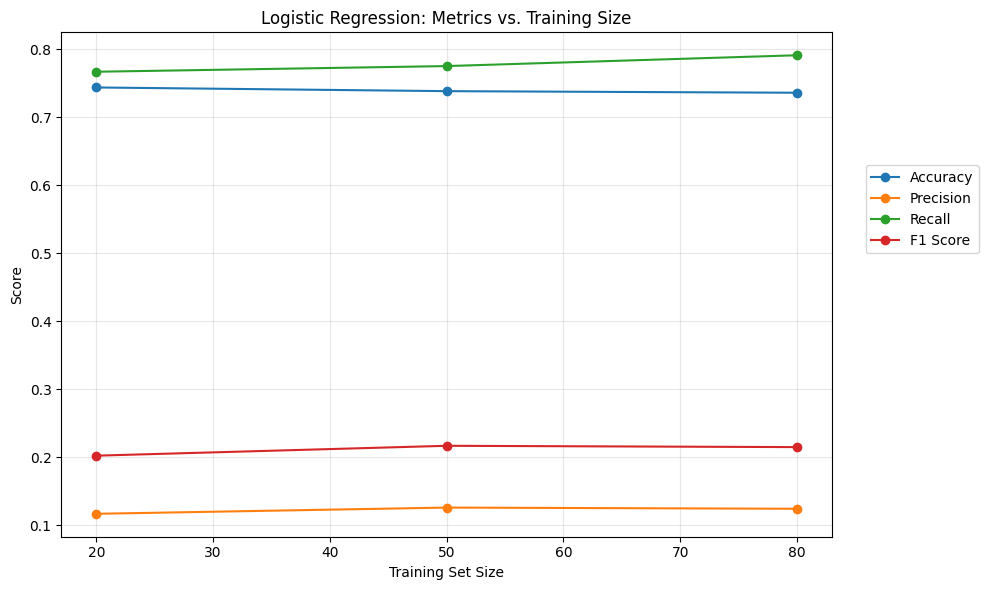

In [159]:
train_sizes = [20, 50, 80]
acc = [stroke_logreg_20_cv['cv_mean_accuracy'],stroke_logreg_50_cv['cv_mean_accuracy'], stroke_logreg_80_cv['cv_mean_accuracy']]
prec = [stroke_logreg_20_cv['cv_mean_precision'], stroke_logreg_50_cv['cv_mean_precision'], stroke_logreg_80_cv['cv_mean_precision']]
rec = [stroke_logreg_20_cv['cv_mean_recall'], stroke_logreg_50_cv['cv_mean_recall'], stroke_logreg_80_cv['cv_mean_recall']]
f1 = [stroke_logreg_20_cv['cv_mean_f1'], stroke_logreg_50_cv['cv_mean_f1'], stroke_logreg_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Logistic Regression: Metrics vs. Training Size")

#### SVC 

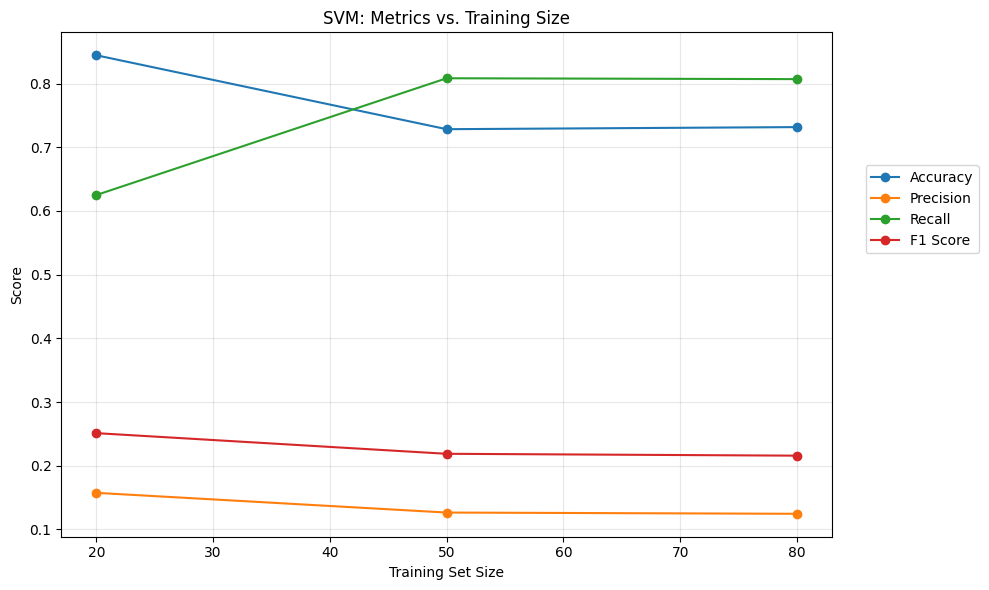

In [160]:
train_sizes = [20, 50, 80]
acc = [stroke_svc_20_cv['cv_mean_accuracy'],stroke_svc_50_cv['cv_mean_accuracy'], stroke_svc_80_cv['cv_mean_accuracy']]
prec = [stroke_svc_20_cv['cv_mean_precision'], stroke_svc_50_cv['cv_mean_precision'], stroke_svc_80_cv['cv_mean_precision']]
rec = [stroke_svc_20_cv['cv_mean_recall'], stroke_svc_50_cv['cv_mean_recall'], stroke_svc_80_cv['cv_mean_recall']]
f1 = [stroke_svc_20_cv['cv_mean_f1'], stroke_svc_50_cv['cv_mean_f1'], stroke_svc_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="SVM: Metrics vs. Training Size")

#### Decision Tree

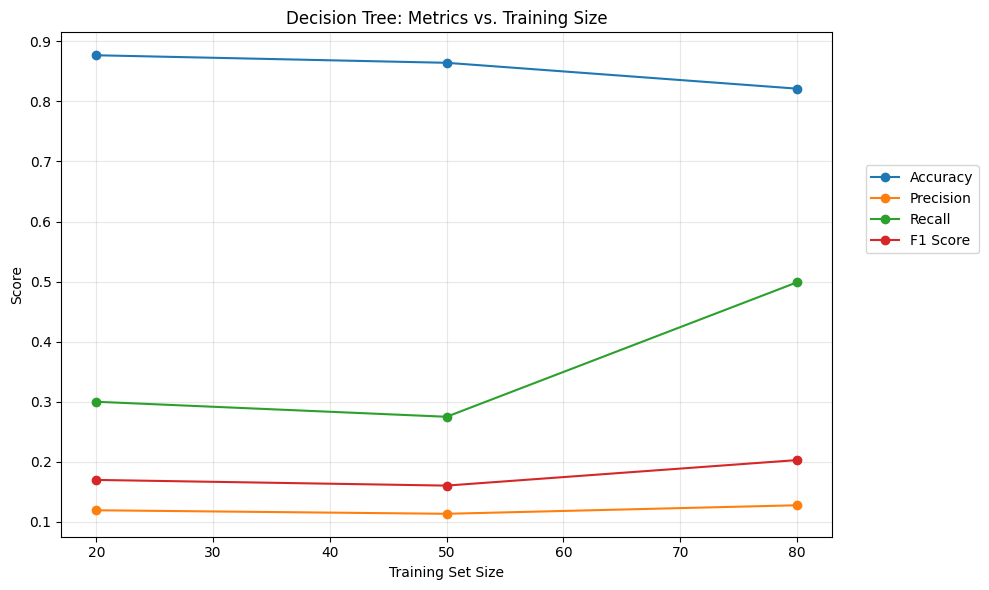

In [161]:
train_sizes = [20, 50, 80]
acc = [stroke_dt_20_cv['cv_mean_accuracy'],stroke_dt_50_cv['cv_mean_accuracy'], stroke_dt_80_cv['cv_mean_accuracy']]
prec = [stroke_dt_20_cv['cv_mean_precision'], stroke_dt_50_cv['cv_mean_precision'], stroke_dt_80_cv['cv_mean_precision']]
rec = [stroke_dt_20_cv['cv_mean_recall'], stroke_dt_50_cv['cv_mean_recall'], stroke_dt_80_cv['cv_mean_recall']]
f1 = [stroke_dt_20_cv['cv_mean_f1'], stroke_dt_50_cv['cv_mean_f1'], stroke_dt_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Decision Tree: Metrics vs. Training Size")

#### Random Forest

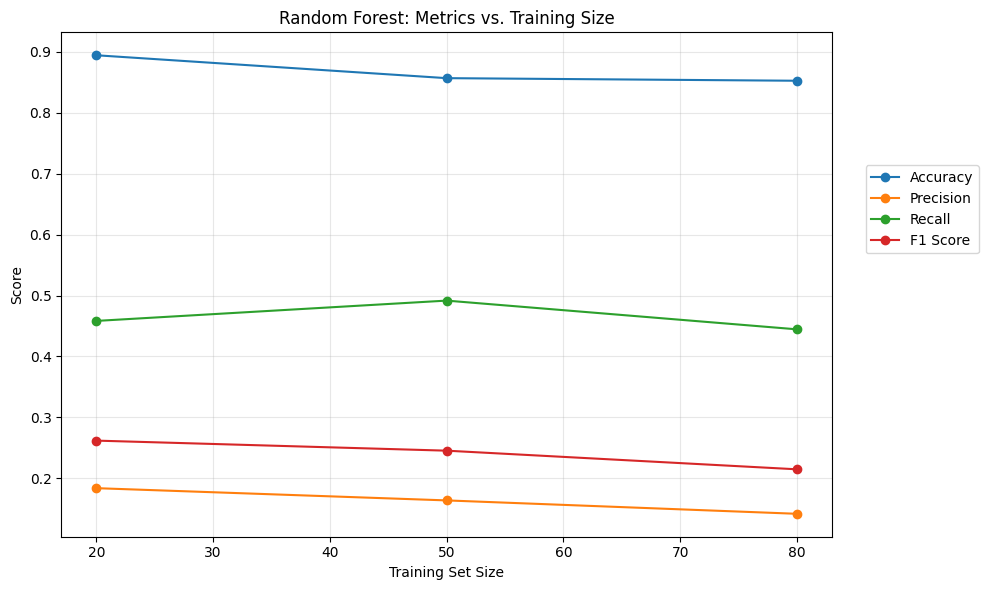

In [162]:
train_sizes = [20, 50, 80]
acc = [stroke_rf_20_cv['cv_mean_accuracy'],stroke_rf_50_cv['cv_mean_accuracy'], stroke_rf_80_cv['cv_mean_accuracy']]
prec = [stroke_rf_20_cv['cv_mean_precision'], stroke_rf_50_cv['cv_mean_precision'], stroke_rf_80_cv['cv_mean_precision']]
rec = [stroke_rf_20_cv['cv_mean_recall'], stroke_rf_50_cv['cv_mean_recall'], stroke_rf_80_cv['cv_mean_recall']]
f1 = [stroke_rf_20_cv['cv_mean_f1'], stroke_rf_50_cv['cv_mean_f1'], stroke_rf_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Random Forest: Metrics vs. Training Size")

## Dataset 2: US Traffic Accidents (2016 - 2023)

### Loading + EDA 

While loading the data, I take a random sample of 80k samples because the original dataset has about 7.7 million entries. <br>
I also decide to use only the most relevant features for predicting severity of an accident because there are about 46 total features in the original dataset, many of which cannot be meaningffully converted into binary categories. 

In [55]:
accident_df = pd.read_csv('US_Accidents_March23.csv')
accident_df = accident_df.sample(n=25000, random_state=42)
accident_df.drop(columns=['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Amenity', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'], inplace=True)
print(f"The shape of dataset2 is: {accident_df.shape}.")
print("Preview of the dataset: ")
accident_df.head()

The shape of dataset2 is: (25000, 23).
Preview of the dataset: 


,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
7133276,1,0.000,78.0,78.0,81.0,30.13,10.0,13.0,0.01,Mostly Cloudy,...,False,False,False,False,False,False,False,True,False,Day
5363845,2,0.045,55.0,55.0,88.0,29.83,10.0,9.0,0.00,Mostly Cloudy,...,False,False,False,False,False,True,False,False,False,Day
155993,3,0.000,91.0,NaN,47.0,29.91,10.0,10.4,NaN,Partly Cloudy,...,False,False,False,False,False,False,False,False,False,Day
1861414,3,0.000,67.0,67.0,84.0,29.78,10.0,3.0,0.00,Cloudy,...,False,False,False,False,False,False,False,False,False,Day
2021359,2,0.000,95.0,95.0,16.0,28.53,10.0,6.0,0.00,Fair,...,False,False,False,False,False,False,False,False,False,Day


In [56]:
print(f"The relevant columns we will use are: {list(accident_df.columns)}")

The relevant columns we will use are: ['Severity', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']


In [57]:
accident_df.describe()

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,25000.000000,25000.000000,24460.000000,18347.000000,24428.000000,24545.000000,24428.000000,23066.000000,17691.000000
mean,2.213920,0.557388,61.443164,57.942034,64.674513,29.543883,9.088464,7.668126,0.008320
std,0.485229,1.659124,19.237641,22.725085,22.872473,0.997391,2.761904,5.267245,0.114435
min,1.000000,0.000000,-35.000000,-41.000000,3.000000,16.720000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,49.000000,42.000000,48.000000,29.380000,10.000000,4.600000,0.000000
50%,2.000000,0.030000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000
75%,2.000000,0.459000,76.000000,75.000000,84.000000,30.040000,10.000000,10.400000,0.000000
max,4.000000,55.312000,114.000000,114.000000,100.000000,30.910000,80.000000,126.600000,10.000000


In [58]:
# Extracting features and predictors of the accident dataset. 
accident_X = accident_df.drop(columns=['Severity'])
print(f"Features: {list(accident_X.columns)}")
accident_y = accident_df['Severity']
print(f"Target is the severity prediction: 1 (high) / 0 (not high)")

Features: ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']
Target is the severity prediction: 1 (high) / 0 (not high)


In [59]:
accident_X_cat_cols = ['Weather_Condition', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']

### 80/20 Split 

In [60]:
# Spilt the dataset into training and test data. 
accident_X_train_80, accident_X_test_80, accident_y_train_80, accident_y_test_80 = split_data(accident_X, accident_y, test_size=0.2, random_state=42)
print(f"Shape of X_training : {accident_X_train_80.shape}")
print(f"Shape of X_testing : {accident_X_test_80.shape}")

Shape of X_training : (20000, 22)
Shape of X_testing : (5000, 22)


In [61]:
# Clean the stroke DataFrame. 
accident_X_train_80, val = impute(accident_X_train_80, method='median')
accident_X_test_80 = impute(accident_X_test_80, method='median', val=val)
# Fill in the missing entries in the categorical features.
accident_X_train_80 = missing_categoricals(accident_X_train_80, accident_X_cat_cols, replace='Missing')
accident_X_test_80 = missing_categoricals(accident_X_test_80, accident_X_cat_cols, replace='Missing')
print(accident_X_train_80.isna().sum())

Distance(mi)         0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64


In [62]:
# Encode categorial features using OneHotEncoding. 
accident_X_train_80, encoder= encode_category(accident_X_train_80, accident_X_cat_cols)
accident_X_test_80, _ = encode_category(accident_X_test_80, accident_X_cat_cols, encoder)

accident_y_train_80 = accident_y_train_80.map({1: 0, 2: 0, 3: 1, 4: 1})
accident_y_test_80 = accident_y_test_80.map({1: 0, 2: 0, 3: 1, 4: 1})

# Standardize numeric features.
accident_X_train_80, sc = standardize_data(accident_X_train_80, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'])
accident_X_test_80, sc2 = standardize_data(accident_X_test_80, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'], scaler=sc)

#### Logistic Regression 

In [63]:
accident_logreg_metrics_80, accident_logreg_80_best = gridsearch_train(
    accident_X_train_80, accident_X_test_80, accident_y_train_80, accident_y_test_80, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

accident_logreg_80_cv = evaluate_with_cv(accident_logreg_80_best, accident_X_train_80, accident_y_train_80)

print(f"The best metrics achieved are: {accident_logreg_metrics_80}")
print(f"The cross-validation results are: {accident_logreg_80_cv}")

The best metrics achieved are: {'accuracy': 0.6384, 'f1_score': 0.42893240682248895, 'precision': 0.31406105457909345, 'recall': 0.6762948207171314}
The cross-validation results are: {'cv_mean_accuracy': 0.6304000000000001, 'cv_mean_precision': 0.2979334438990785, 'cv_mean_recall': 0.652377161055505, 'cv_mean_f1': 0.40904161415292695}


#### Support Vector Classifier 

In [64]:
accident_svc_metrics_80, accident_svc_80_best = gridsearch_train(
    accident_X_train_80, accident_X_test_80, accident_y_train_80, accident_y_test_80, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

accident_svc_80_cv = evaluate_with_cv(accident_svc_80_best, accide nt_X_train_80, accident_y_train_80)

print(f"The best metrics achieved are: {accident_svc_metrics_80}")
print(f"The cross-validation results are: {accident_svc_80_cv}")

The best metrics achieved are: {'accuracy': 0.6846, 'f1_score': 0.4507140369209335, 'precision': 0.3465452597750402, 'recall': 0.6444223107569721}
The cross-validation results are: {'cv_mean_accuracy': 0.6816999999999999, 'cv_mean_precision': 0.3380866129347758, 'cv_mean_recall': 0.6513567528922397, 'cv_mean_f1': 0.44511638057814906}


#### Decision Tree

In [65]:
accident_dt_metrics_80, accident_dt_80_best = gridsearch_train(
    accident_X_train_80, accident_X_test_80, accident_y_train_80, accident_y_test_80, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

accident_dt_80_cv = evaluate_with_cv(accident_dt_80_best, accident_X_train_80, accident_y_train_80)

print(f"The best metrics achieved are: {accident_dt_metrics_80}")
print(f"The cross-validation results are: {accident_dt_80_cv}")

The best metrics achieved are: {'accuracy': 0.7098, 'f1_score': 0.5022298456260721, 'precision': 0.38304552590266877, 'recall': 0.7290836653386454}
The cross-validation results are: {'cv_mean_accuracy': 0.70785, 'cv_mean_precision': 0.3748262043903222, 'cv_mean_recall': 0.7334801117899389, 'cv_mean_f1': 0.4960662867990614}


#### Random Forest 

In [66]:
accident_rf_metrics_80, accident_rf_80_best = gridsearch_train(
    accident_X_train_80, accident_X_test_80, accident_y_train_80, accident_y_test_80, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

accident_rf_80_cv = evaluate_with_cv(accident_rf_80_best, accident_X_train_80, accident_y_train_80)

print(f"The best metrics achieved are: {accident_rf_metrics_80}")
print(f"The cross-validation results are: {accident_rf_80_cv}")

The best metrics achieved are: {'accuracy': 0.7258, 'f1_score': 0.5244536940686785, 'precision': 0.4023416711016498, 'recall': 0.7529880478087649}
The cross-validation results are: {'cv_mean_accuracy': 0.72495, 'cv_mean_precision': 0.3917829014213453, 'cv_mean_recall': 0.7286328480436761, 'cv_mean_f1': 0.5094864941298353}


#### Comparing the classifiers on 80/20 split 

In [67]:
data_8020_accident = {
    'Logistic Regression': accident_logreg_80_cv,
    'Support Vector Classifier': accident_svc_80_cv,
    'Decistion Tree': accident_dt_80_cv,
    'Random Forest': accident_rf_80_cv
}
accident_perf_8020 = pd.DataFrame.from_dict(data_8020_accident, orient='index')
accident_perf_8020.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("80/20 split - Performance by classifiers: ")
print(accident_perf_8020)

80/20 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression         0.63040  0.297933   0.652377  0.409042
Support Vector Classifier   0.68170  0.338087   0.651357  0.445116
Decistion Tree              0.70785  0.374826   0.733480  0.496066
Random Forest               0.72495  0.391783   0.728633  0.509486


### 50/50 Split 

In [68]:
# Spilt the dataset into training and test data. 
accident_X_train_50, accident_X_test_50, accident_y_train_50, accident_y_test_50 = split_data(accident_X, accident_y, test_size=0.5, random_state=42)
print(f"Shape of X_training : {accident_X_train_50.shape}")
print(f"Shape of X_testing : {accident_X_test_50.shape}")

Shape of X_training : (12500, 22)
Shape of X_testing : (12500, 22)


In [69]:
# Clean the stroke DataFrame. 
accident_X_train_50, val = impute(accident_X_train_50, method='median')
accident_X_test_50 = impute(accident_X_test_50, method='median', val=val)
# Fill in the missing entries in the categorical features.
accident_X_train_50 = missing_categoricals(accident_X_train_50, accident_X_cat_cols, replace='Missing')
accident_X_test_50 = missing_categoricals(accident_X_test_50, accident_X_cat_cols, replace='Missing')
print(accident_X_train_50.isna().sum())

Distance(mi)         0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64


In [70]:
# Encode categorical features into 0s and 1s.
accident_X_train_50, encoder = encode_category(accident_X_train_50, accident_X_cat_cols)
accident_X_test_50, _ = encode_category(accident_X_test_50, accident_X_cat_cols, encoder)

accident_y_train_50 = accident_y_train_50.map({1: 0, 2: 0, 3: 1, 4: 1})
accident_y_test_50 = accident_y_test_50.map({1: 0, 2: 0, 3: 1, 4: 1})

# Standardize numeric features.
accident_X_train_50, sc = standardize_data(accident_X_train_50, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'])
accident_X_test_50, sc2 = standardize_data(accident_X_test_50, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'], scaler=sc)

#### Logistic Regression 

In [71]:
accident_logreg_metrics_50, accident_logreg_50_best = gridsearch_train(
    accident_X_train_50, accident_X_test_50, accident_y_train_50, accident_y_test_50, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

accident_logreg_50_cv = evaluate_with_cv(accident_logreg_50_best, accident_X_train_50, accident_y_train_50)

print(f"The best metrics achieved are: {accident_logreg_metrics_50}")
print(f"The cross-validation results are: {accident_logreg_50_cv}")

The best metrics achieved are: {'accuracy': 0.63568, 'f1_score': 0.4134466769706337, 'precision': 0.30420773313115995, 'recall': 0.645096463022508}
The cross-validation results are: {'cv_mean_accuracy': 0.63208, 'cv_mean_precision': 0.2973180213374519, 'cv_mean_recall': 0.6491702292388999, 'cv_mean_f1': 0.40780251083451285}


#### Support Vector Classifier 

In [72]:
accident_svc_metrics_50, accident_svc_50_best = gridsearch_train(
    accident_X_train_50, accident_X_test_50, accident_y_train_50, accident_y_test_50, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

accident_svc_50_cv = evaluate_with_cv(accident_svc_50_best, accident_X_train_50, accident_y_train_50)

print(f"The best metrics achieved are: {accident_svc_metrics_50}")
print(f"The cross-validation results are: {accident_svc_50_cv}")

The best metrics achieved are: {'accuracy': 0.68032, 'f1_score': 0.4403361344537815, 'precision': 0.3379191745485813, 'recall': 0.6318327974276527}
The cross-validation results are: {'cv_mean_accuracy': 0.6739999999999999, 'cv_mean_precision': 0.32536558738434856, 'cv_mean_recall': 0.624549769414616, 'cv_mean_f1': 0.42779141006113985}


#### Decision Tree 

In [73]:
accident_dt_metrics_50, accident_dt_50_best = gridsearch_train(
    accident_X_train_50, accident_X_test_50, accident_y_train_50, accident_y_test_50, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

accident_dt_50_cv = evaluate_with_cv(accident_dt_50_best, accident_X_train_50, accident_y_train_50)

print(f"The best metrics achieved are: {accident_dt_metrics_50}")
print(f"The cross-validation results are: {accident_dt_50_cv}")

The best metrics achieved are: {'accuracy': 0.70552, 'f1_score': 0.4976115736317729, 'precision': 0.376730729489564, 'recall': 0.7327170418006431}
The cross-validation results are: {'cv_mean_accuracy': 0.6908, 'cv_mean_precision': 0.3576692158772768, 'cv_mean_recall': 0.7345272158077221, 'cv_mean_f1': 0.4807369807868455}


#### Random Forest 

In [74]:
accident_rf_metrics_50, accident_rf_50_best = gridsearch_train(
    accident_X_train_50, accident_X_test_50, accident_y_train_50, accident_y_test_50, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

accident_rf_50_cv = evaluate_with_cv(accident_rf_50_best, accident_X_train_50, accident_y_train_50)

print(f"The best metrics achieved are: {accident_rf_metrics_50}")
print(f"The cross-validation results are: {accident_rf_50_cv}")

The best metrics achieved are: {'accuracy': 0.72312, 'f1_score': 0.5126038586114632, 'precision': 0.3945371775417299, 'recall': 0.7315112540192926}
The cross-validation results are: {'cv_mean_accuracy': 0.72536, 'cv_mean_precision': 0.3899451068086529, 'cv_mean_recall': 0.723851280842899, 'cv_mean_f1': 0.5068192728366221}


#### Comparing the classifiers on 50/50 split 

In [75]:
data_5050_accident = {
    'Logistic Regression': accident_logreg_50_cv,
    'Support Vector Classifier': accident_svc_50_cv,
    'Decistion Tree': accident_dt_50_cv,
    'Random Forest': accident_rf_50_cv
}
accident_perf_5050 = pd.DataFrame.from_dict(data_5050_accident, orient='index')
accident_perf_5050.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("50/50 split - Performance by classifiers: ")
print(accident_perf_5050)

50/50 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression         0.63208  0.297318   0.649170  0.407803
Support Vector Classifier   0.67400  0.325366   0.624550  0.427791
Decistion Tree              0.69080  0.357669   0.734527  0.480737
Random Forest               0.72536  0.389945   0.723851  0.506819


### 20/80 Split 

In [76]:
# Spilt the dataset into training and test data. 
accident_X_train_20, accident_X_test_20, accident_y_train_20, accident_y_test_20 = split_data(accident_X, accident_y, test_size=0.8, random_state=42)
print(f"Shape of X_training : {accident_X_train_20.shape}")
print(f"Shape of X_testing : {accident_X_test_20.shape}")

Shape of X_training : (5000, 22)
Shape of X_testing : (20000, 22)


In [77]:
# Clean the stroke DataFrame. 
accident_X_train_20, val = impute(accident_X_train_20, method='median')
accident_X_test_20 = impute(accident_X_test_20, method='median', val=val)
# Fill in the missing entries in the categorical features.
accident_X_train_20 = missing_categoricals(accident_X_train_20, accident_X_cat_cols, replace='Missing')
accident_X_test_20 = missing_categoricals(accident_X_test_20, accident_X_cat_cols, replace='Missing')
print(accident_X_train_20.isna().sum())

Distance(mi)         0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64


In [78]:
# Encode categorical features into 0s and 1s.
accident_X_train_20, encoder = encode_category(accident_X_train_20, accident_X_cat_cols)
accident_X_test_20, _ = encode_category(accident_X_test_20, accident_X_cat_cols, encoder)

accident_y_train_20 = accident_y_train_20.map({1: 0, 2: 0, 3: 1, 4: 1})
accident_y_test_20 = accident_y_test_20.map({1: 0, 2: 0, 3: 1, 4: 1})

# Standardize numeric features.
accident_X_train_20, sc = standardize_data(accident_X_train_20, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'])
accident_X_test_20, sc2 = standardize_data(accident_X_test_20, ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'], scaler=sc)

#### Logistic Regression 

In [79]:
accident_logreg_metrics_20, accident_logreg_20_best = gridsearch_train(
    accident_X_train_20, accident_X_test_20, accident_y_train_20, accident_y_test_20, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

accident_logreg_20_cv = evaluate_with_cv(accident_logreg_20_best, accident_X_train_20, accident_y_train_20)

print(f"The best metrics achieved are: {accident_logreg_metrics_20}")
print(f"The cross-validation results are: {accident_logreg_20_cv}")

The best metrics achieved are: {'accuracy': 0.64505, 'f1_score': 0.410431027323312, 'precision': 0.306271690629648, 'recall': 0.621948150012585}
The cross-validation results are: {'cv_mean_accuracy': 0.6436, 'cv_mean_precision': 0.297412850144653, 'cv_mean_recall': 0.6397354643152384, 'cv_mean_f1': 0.4059116711543118}


#### Support Vector Classifier 

In [80]:
accident_svc_metrics_20, accident_svc_20_best = gridsearch_train(
    accident_X_train_20, accident_X_test_20, accident_y_train_20, accident_y_test_20, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

accident_svc_20_cv = evaluate_with_cv(accident_svc_20_best, accident_X_train_20, accident_y_train_20)

print(f"The best metrics achieved are: {accident_svc_metrics_20}")
print(f"The cross-validation results are: {accident_svc_20_cv}")

The best metrics achieved are: {'accuracy': 0.6678, 'f1_score': 0.42466227918254246, 'precision': 0.3236963696369637, 'recall': 0.6171658696199346}
The cross-validation results are: {'cv_mean_accuracy': 0.6602, 'cv_mean_precision': 0.31031278145858704, 'cv_mean_recall': 0.6386718104160926, 'cv_mean_f1': 0.41746311461722974}


#### Decision Tree

In [81]:
accident_dt_metrics_20, accident_dt_20_best = gridsearch_train(
    accident_X_train_20, accident_X_test_20, accident_y_train_20, accident_y_test_20, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

accident_dt_20_cv = evaluate_with_cv(accident_dt_20_best, accident_X_train_20, accident_y_train_20)

print(f"The best metrics achieved are: {accident_dt_metrics_20}")
print(f"The cross-validation results are: {accident_dt_20_cv}")

The best metrics achieved are: {'accuracy': 0.70645, 'f1_score': 0.4934863255974463, 'precision': 0.37542662116040953, 'recall': 0.7198590485779008}
The cross-validation results are: {'cv_mean_accuracy': 0.7022, 'cv_mean_precision': 0.35698665085725156, 'cv_mean_recall': 0.6975475337558557, 'cv_mean_f1': 0.4715553998181597}


#### Random Forest

In [82]:
accident_rf_metrics_20, accident_rf_20_best = gridsearch_train(
    accident_X_train_20, accident_X_test_20, accident_y_train_20, accident_y_test_20, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

accident_rf_20_cv = evaluate_with_cv(accident_rf_20_best, accident_X_train_20, accident_y_train_20)

print(f"The best metrics achieved are: {accident_rf_metrics_20}")
print(f"The cross-validation results are: {accident_rf_20_cv}")

The best metrics achieved are: {'accuracy': 0.72385, 'f1_score': 0.5037289963159314, 'precision': 0.3916992733370598, 'recall': 0.7055122073999497}
The cross-validation results are: {'cv_mean_accuracy': 0.729, 'cv_mean_precision': 0.3845884646614829, 'cv_mean_recall': 0.7048883990079912, 'cv_mean_f1': 0.49723447658664355}


#### Comparing the classifiers on 20/80 split 

In [154]:
data_2080_accident = {
    'Logistic Regression': accident_logreg_20_cv,
    'Support Vector Classifier': accident_svc_20_cv,
    'Decistion Tree': accident_dt_20_cv,
    'Random Forest': accident_rf_20_cv
}
perf_2080 = pd.DataFrame.from_dict(data_2080_accident, orient='index')
perf_2080.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("20/80 split - Performance by classifiers: ")
print(perf_2080)

20/80 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression          0.6436  0.297413   0.639735  0.405912
Support Vector Classifier    0.6602  0.310313   0.638672  0.417463
Decistion Tree               0.7022  0.356987   0.697548  0.471555
Random Forest                0.7290  0.384588   0.704888  0.497234


### Performance vs Training Size per Classifier 

#### Logistic Regression

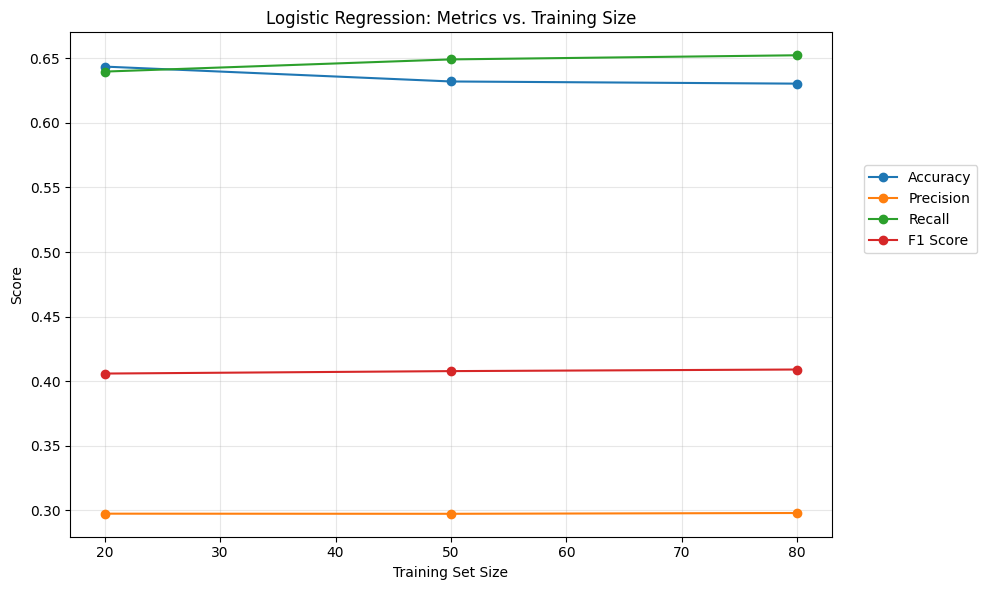

In [155]:
train_sizes = [20, 50, 80]
acc = [accident_logreg_20_cv['cv_mean_accuracy'],accident_logreg_50_cv['cv_mean_accuracy'], accident_logreg_80_cv['cv_mean_accuracy']]
prec = [accident_logreg_20_cv['cv_mean_precision'], accident_logreg_50_cv['cv_mean_precision'], accident_logreg_80_cv['cv_mean_precision']]
rec = [accident_logreg_20_cv['cv_mean_recall'], accident_logreg_50_cv['cv_mean_recall'], accident_logreg_80_cv['cv_mean_recall']]
f1 = [accident_logreg_20_cv['cv_mean_f1'], accident_logreg_50_cv['cv_mean_f1'], accident_logreg_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Logistic Regression: Metrics vs. Training Size")

#### SVM

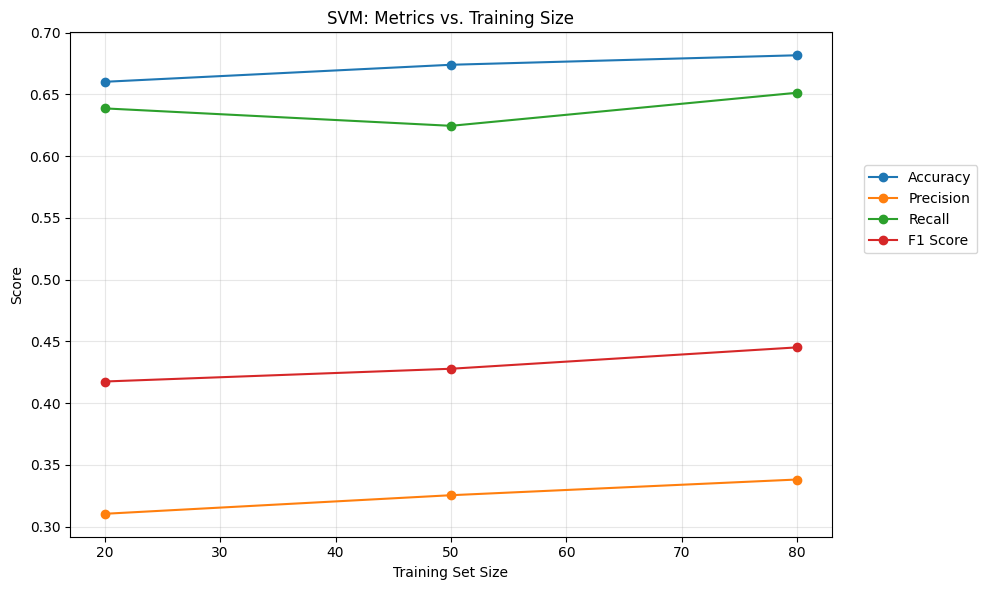

In [156]:
train_sizes = [20, 50, 80]
acc = [accident_svc_20_cv['cv_mean_accuracy'],accident_svc_50_cv['cv_mean_accuracy'], accident_svc_80_cv['cv_mean_accuracy']]
prec = [accident_svc_20_cv['cv_mean_precision'], accident_svc_50_cv['cv_mean_precision'], accident_svc_80_cv['cv_mean_precision']]
rec = [accident_svc_20_cv['cv_mean_recall'], accident_svc_50_cv['cv_mean_recall'], accident_svc_80_cv['cv_mean_recall']]
f1 = [accident_svc_20_cv['cv_mean_f1'], accident_svc_50_cv['cv_mean_f1'], accident_svc_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="SVM: Metrics vs. Training Size")

#### Decision Tree

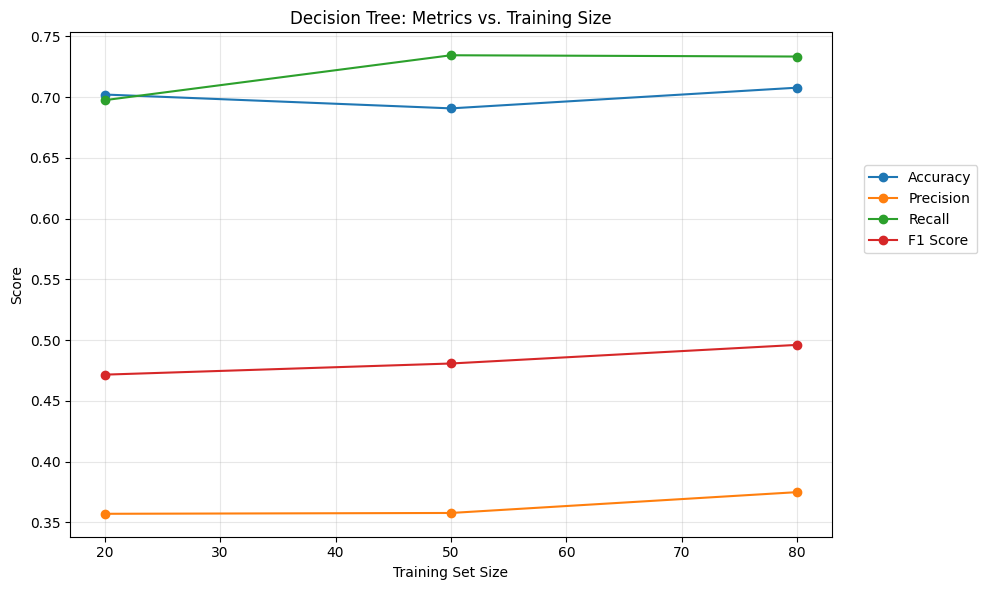

In [157]:
train_sizes = [20, 50, 80]
acc = [accident_dt_20_cv['cv_mean_accuracy'],accident_dt_50_cv['cv_mean_accuracy'], accident_dt_80_cv['cv_mean_accuracy']]
prec = [accident_dt_20_cv['cv_mean_precision'], accident_dt_50_cv['cv_mean_precision'], accident_dt_80_cv['cv_mean_precision']]
rec = [accident_dt_20_cv['cv_mean_recall'], accident_dt_50_cv['cv_mean_recall'], accident_dt_80_cv['cv_mean_recall']]
f1 = [accident_dt_20_cv['cv_mean_f1'], accident_dt_50_cv['cv_mean_f1'], accident_dt_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Decision Tree: Metrics vs. Training Size")

#### Random Forest

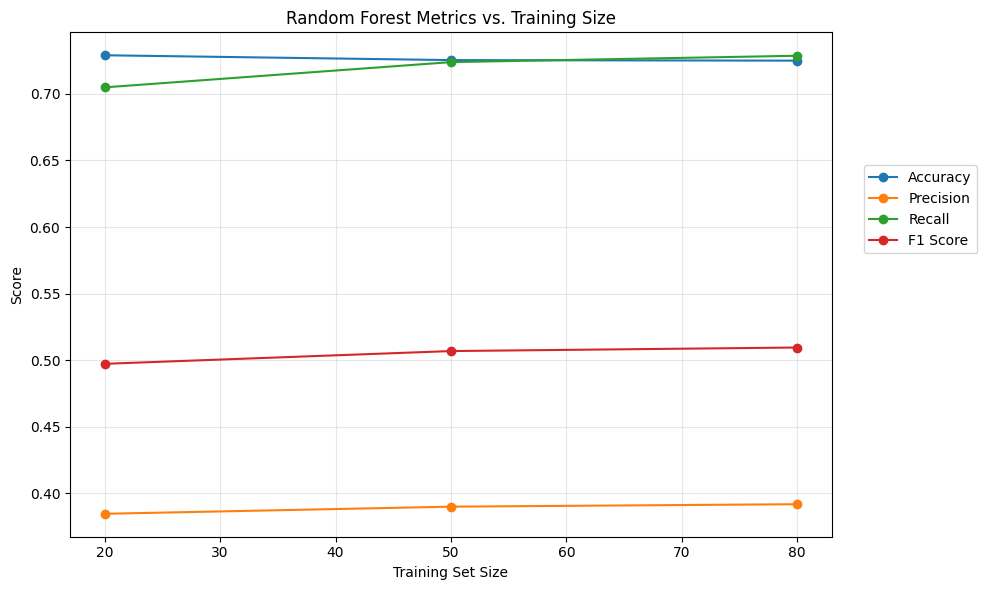

In [158]:
train_sizes = [20, 50, 80]
acc = [accident_rf_20_cv['cv_mean_accuracy'],accident_rf_50_cv['cv_mean_accuracy'], accident_rf_80_cv['cv_mean_accuracy']]
prec = [accident_rf_20_cv['cv_mean_precision'], accident_rf_50_cv['cv_mean_precision'], accident_rf_80_cv['cv_mean_precision']]
rec = [accident_rf_20_cv['cv_mean_recall'], accident_rf_50_cv['cv_mean_recall'], accident_rf_80_cv['cv_mean_recall']]
f1 = [accident_rf_20_cv['cv_mean_f1'], accident_rf_50_cv['cv_mean_f1'], accident_rf_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Random Forest Metrics vs. Training Size")

## Dataset 3: Telco Customer Churn

### Loading + EDA 

In [96]:
churn_df = pd.read_csv('telco_churn.csv')
print(f"The shape of dataset1 is: {churn_df.shape}.")
print("Preview of the dataset: ")
churn_df.head()

The shape of dataset1 is: (7043, 21).
Preview of the dataset: 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [97]:
churn_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [98]:
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')

In [99]:
# Delete the Customer ID column because it is not a meaningful predictor. 
churn_df.drop(columns=['customerID'], inplace=True)
churn_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [100]:
churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [101]:
churn_df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [102]:
# Extracting features and predictors of the stroke dataset. 
churn_X = churn_df.drop(columns=['Churn'])
print(f"Features: {list(churn_X.columns)}")
churn_y = churn_df['Churn']
print(f"Target is the churn prediction: 1  / 0 ")

Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Target is the churn prediction: 1  / 0 


In [103]:
churn_X_cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

### 80/20 Split 

In [104]:
# Spilt the dataset into training and test data. 
churn_X_train_80, churn_X_test_80, churn_y_train_80, churn_y_test_80 = split_data(churn_X, churn_y, test_size=0.2, random_state=42)
print(f"Shape of X_training : {churn_X_train_80.shape}")
print(f"Shape of X_testing : {churn_X_test_80.shape}")

Shape of X_training : (5634, 19)
Shape of X_testing : (1409, 19)


In [105]:
# Clean the stroke DataFrame. 
churn_X_train_80, val = impute(churn_X_train_80, method='median')
churn_X_test_80 = impute(churn_X_test_80, method='median', val=val)
# Fill in the missing entries in the categorical features.
churn_X_train_80 = missing_categoricals(churn_X_train_80, churn_X_cat_cols, replace='Missing')
churn_X_test_80 = missing_categoricals(churn_X_test_80, churn_X_cat_cols, replace='Missing')
print(churn_X_train_80.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [106]:
churn_X_train_80 = churn_X_train_80.replace(r'^\s*$', np.nan, regex=True)
churn_X_test_80  = churn_X_test_80.replace(r'^\s*$', np.nan, regex=True)

# Encode categorical features using OneHotEncoding. 
churn_X_train_80, encoder= encode_category(churn_X_train_80, churn_X_cat_cols)
churn_X_test_80, _ = encode_category(churn_X_test_80, churn_X_cat_cols, encoder)

churn_y_train_80 = churn_y_train_80.map({'Yes': 1, 'No': 0})
churn_y_test_80 = churn_y_test_80.map({'Yes': 1, 'No': 0})

# Standardize numeric features.
churn_X_train_80, sc = standardize_data(churn_X_train_80, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])
churn_X_test_80, sc2 = standardize_data(churn_X_test_80, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

In [107]:
churn_X_train_80.isna().sum()


SeniorCitizen                              0
tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
gender_Female                              0
gender_Male                                0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_No phone service             0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_No internet service         0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBack

### Logistic Regression 

In [108]:
churn_logreg_metrics_80, churn_logreg_80_best = gridsearch_train(
    churn_X_train_80, churn_X_test_80, churn_y_train_80, churn_y_test_80, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

churn_logreg_80_cv = evaluate_with_cv(churn_logreg_80_best, churn_X_train_80, churn_y_train_80)

print(f"The best metrics achieved are: {churn_logreg_metrics_80}")
print(f"The cross-validation results are: {churn_logreg_80_cv}")

print(churn_logreg_metrics_80)

The best metrics achieved are: {'accuracy': 0.7487579843860894, 'f1_score': 0.6358024691358025, 'precision': 0.5158597662771286, 'recall': 0.8284182305630027}
The cross-validation results are: {'cv_mean_accuracy': 0.7413961522519271, 'cv_mean_precision': 0.5084224040854121, 'cv_mean_recall': 0.7974626532887402, 'cv_mean_f1': 0.6209284330482053}
{'accuracy': 0.7487579843860894, 'f1_score': 0.6358024691358025, 'precision': 0.5158597662771286, 'recall': 0.8284182305630027}


#### Support Vector Classifier 

In [110]:
churn_svc_metrics_80, churn_svc_80_best = gridsearch_train(
    churn_X_train_80, churn_X_test_80, churn_y_train_80, churn_y_test_80, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

churn_svc_80_cv = evaluate_with_cv(churn_svc_80_best, churn_X_train_80, churn_y_train_80)

print(f"The best metrics achieved are: {churn_svc_metrics_80}")
print(f"The cross-validation results are: {churn_svc_80_cv}")

The best metrics achieved are: {'accuracy': 0.7650816181689141, 'f1_score': 0.6421621621621622, 'precision': 0.5380434782608695, 'recall': 0.7962466487935657}
The cross-validation results are: {'cv_mean_accuracy': 0.7468981136357548, 'cv_mean_precision': 0.5157660093437284, 'cv_mean_recall': 0.7800869565217392, 'cv_mean_f1': 0.6208396497166857}


#### Decision Tree

In [111]:
churn_dt_metrics_80, churn_dt_80_best = gridsearch_train(
    churn_X_train_80, churn_X_test_80, churn_y_train_80, churn_y_test_80, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

churn_dt_80_cv = evaluate_with_cv(churn_dt_80_best, churn_X_train_80, churn_y_train_80)

print(f"The best metrics achieved are: {churn_dt_metrics_80}")
print(f"The cross-validation results are: {churn_dt_80_cv}")

The best metrics achieved are: {'accuracy': 0.7203690560681334, 'f1_score': 0.606, 'precision': 0.48325358851674644, 'recall': 0.8123324396782842}
The cross-validation results are: {'cv_mean_accuracy': 0.731278437701438, 'cv_mean_precision': 0.49682053100789886, 'cv_mean_recall': 0.7854002229654403, 'cv_mean_f1': 0.6081711907906127}


#### Random Forest

In [112]:
churn_rf_metrics_80, churn_rf_80_best = gridsearch_train(
    churn_X_train_80, churn_X_test_80, churn_y_train_80, churn_y_test_80, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

churn_rf_80_cv = evaluate_with_cv(churn_rf_80_best, churn_X_train_80, churn_y_train_80)

print(f"The best metrics achieved are: {churn_rf_metrics_80}")
print(f"The cross-validation results are: {churn_rf_80_cv}")

The best metrics achieved are: {'accuracy': 0.7799858055358411, 'f1_score': 0.651685393258427, 'precision': 0.5609284332688588, 'recall': 0.7774798927613941}
The cross-validation results are: {'cv_mean_accuracy': 0.7603874540780866, 'cv_mean_precision': 0.5344968331480425, 'cv_mean_recall': 0.7586978818283165, 'cv_mean_f1': 0.6271481544404907}


#### Comparing the classifiers on 80/20 split 

In [113]:
data_8020_churn = {
    'Logistic Regression': churn_logreg_80_cv,
    'Support Vector Classifier': churn_svc_80_cv,
    'Decistion Tree': churn_dt_80_cv,
    'Random Forest': churn_rf_80_cv
}
perf_8020_churn = pd.DataFrame.from_dict(data_8020_churn, orient='index')
perf_8020_churn.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("80/20 split - Performance by classifiers: ")
print(perf_8020_churn)

80/20 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.741396  0.508422   0.797463  0.620928
Support Vector Classifier  0.746898  0.515766   0.780087  0.620840
Decistion Tree             0.731278  0.496821   0.785400  0.608171
Random Forest              0.760387  0.534497   0.758698  0.627148


### 50/50 Split

In [114]:
# Spilt the dataset into training and test data. 
churn_X_train_50, churn_X_test_50, churn_y_train_50, churn_y_test_50 = split_data(churn_X, churn_y, test_size=0.5, random_state=42)
print(f"Shape of X_training : {churn_X_train_50.shape}")
print(f"Shape of X_testing : {churn_X_test_50.shape}")

Shape of X_training : (3521, 19)
Shape of X_testing : (3522, 19)


In [115]:
# Clean the stroke DataFrame. 
churn_X_train_50, val = impute(churn_X_train_50, method='median')
churn_X_test_50 = impute(churn_X_test_50, method='median', val=val)
# Fill in the missing entries in the categorical features.
churn_X_train_50 = missing_categoricals(churn_X_train_50, churn_X_cat_cols, replace='Missing')
churn_X_test_50 = missing_categoricals(churn_X_test_50, churn_X_cat_cols, replace='Missing')
print(churn_X_train_50.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [116]:
churn_X_train_50 = churn_X_train_50.replace(r'^\s*$', np.nan, regex=True)
churn_X_test_50  = churn_X_test_50.replace(r'^\s*$', np.nan, regex=True)

# Encode categorical features using OneHotEncoding. 
churn_X_train_50, encoder= encode_category(churn_X_train_50, churn_X_cat_cols)
churn_X_test_50, _ = encode_category(churn_X_test_50, churn_X_cat_cols, encoder)

churn_y_train_50 = churn_y_train_50.map({'Yes': 1, 'No': 0})
churn_y_test_50 = churn_y_test_50.map({'Yes': 1, 'No': 0})

# Standardize numeric features.
churn_X_train_50, sc = standardize_data(churn_X_train_50, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])
churn_X_test_50, sc2 = standardize_data(churn_X_test_50, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

#### Logistic Regression

In [117]:
churn_logreg_metrics_50, churn_logreg_50_best = gridsearch_train(
    churn_X_train_50, churn_X_test_50, churn_y_train_50, churn_y_test_50, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

churn_logreg_50_cv = evaluate_with_cv(churn_logreg_50_best, churn_X_train_50, churn_y_train_50)

print(f"The best metrics achieved are: {churn_logreg_metrics_50}")
print(f"The cross-validation results are: {churn_logreg_50_cv}")

print(churn_logreg_metrics_50)

The best metrics achieved are: {'accuracy': 0.7447473026689381, 'f1_score': 0.6388107673764564, 'precision': 0.5152300712896954, 'recall': 0.8403805496828752}
The cross-validation results are: {'cv_mean_accuracy': 0.7304722759509994, 'cv_mean_precision': 0.49169683007147685, 'cv_mean_recall': 0.7876321974148061, 'cv_mean_f1': 0.6052126578295977}
{'accuracy': 0.7447473026689381, 'f1_score': 0.6388107673764564, 'precision': 0.5152300712896954, 'recall': 0.8403805496828752}


#### Support Vector Classifier 

In [118]:
churn_svc_metrics_50, churn_svc_50_best = gridsearch_train(
    churn_X_train_50, churn_X_test_50, churn_y_train_50, churn_y_test_50, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

churn_svc_50_cv = evaluate_with_cv(churn_svc_50_best, churn_X_train_50, churn_y_train_50)

print(f"The best metrics achieved are: {churn_svc_metrics_50}")
print(f"The cross-validation results are: {churn_svc_50_cv}")

The best metrics achieved are: {'accuracy': 0.747870528109029, 'f1_score': 0.6363636363636364, 'precision': 0.5193850267379679, 'recall': 0.821353065539112}
The cross-validation results are: {'cv_mean_accuracy': 0.7313237427466152, 'cv_mean_precision': 0.49268340601791233, 'cv_mean_recall': 0.7681198589894243, 'cv_mean_f1': 0.599822978702354}


#### Decision Tree

In [119]:
churn_dt_metrics_50, churn_dt_50_best = gridsearch_train(
    churn_X_train_50, churn_X_test_50, churn_y_train_50, churn_y_test_50, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

churn_dt_50_cv = evaluate_with_cv(churn_dt_50_best, churn_X_train_50, churn_y_train_50)

print(f"The best metrics achieved are: {churn_dt_metrics_50}")
print(f"The cross-validation results are: {churn_dt_50_cv}")

The best metrics achieved are: {'accuracy': 0.7237365133446905, 'f1_score': 0.6106442577030813, 'precision': 0.49130714745653575, 'recall': 0.806553911205074}
The cross-validation results are: {'cv_mean_accuracy': 0.6898621856866538, 'cv_mean_precision': 0.44933366823201626, 'cv_mean_recall': 0.7789600470035252, 'cv_mean_f1': 0.5691002323264955}


#### Random Forest 

In [120]:
churn_rf_metrics_50, churn_rf_50_best = gridsearch_train(
    churn_X_train_50, churn_X_test_50, churn_y_train_50, churn_y_test_50, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

churn_rf_50_cv = evaluate_with_cv(churn_rf_50_best, churn_X_train_50, churn_y_train_50)

print(f"The best metrics achieved are: {churn_rf_metrics_50}")
print(f"The cross-validation results are: {churn_rf_50_cv}")

The best metrics achieved are: {'accuracy': 0.7708688245315162, 'f1_score': 0.6514038876889848, 'precision': 0.5507669831994156, 'recall': 0.7970401691331924}
The cross-validation results are: {'cv_mean_accuracy': 0.7554662314635718, 'cv_mean_precision': 0.5236996880536887, 'cv_mean_recall': 0.7507873090481786, 'cv_mean_f1': 0.6168129159153979}


#### Comparing the classifiers on 50/50 split 

In [121]:
data_5050_churn = {
    'Logistic Regression': churn_logreg_50_cv,
    'Support Vector Classifier': churn_svc_50_cv,
    'Decistion Tree': churn_dt_50_cv,
    'Random Forest': churn_rf_50_cv
}
perf_5050_churn = pd.DataFrame.from_dict(data_5050_churn, orient='index')
perf_5050_churn.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("50/50 split - Performance by classifiers: ")
print(perf_5050_churn)

50/50 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.730472  0.491697   0.787632  0.605213
Support Vector Classifier  0.731324  0.492683   0.768120  0.599823
Decistion Tree             0.689862  0.449334   0.778960  0.569100
Random Forest              0.755466  0.523700   0.750787  0.616813


### 20/80 Split

In [122]:
# Spilt the dataset into training and test data. 
churn_X_train_20, churn_X_test_20, churn_y_train_20, churn_y_test_20 = split_data(churn_X, churn_y, test_size=0.2, random_state=42)
print(f"Shape of X_training : {churn_X_train_20.shape}")
print(f"Shape of X_testing : {churn_X_test_20.shape}")

Shape of X_training : (5634, 19)
Shape of X_testing : (1409, 19)


In [123]:
# Clean the stroke DataFrame. 
churn_X_train_20, val = impute(churn_X_train_20, method='median')
churn_X_test_20 = impute(churn_X_test_20, method='median', val=val)
# Fill in the missing entries in the categorical features.
churn_X_train_20 = missing_categoricals(churn_X_train_20, churn_X_cat_cols, replace='Missing')
churn_X_test_20 = missing_categoricals(churn_X_test_20, churn_X_cat_cols, replace='Missing')
print(churn_X_train_20.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [124]:
churn_X_train_20 = churn_X_train_20.replace(r'^\s*$', np.nan, regex=True)
churn_X_test_20  = churn_X_test_20.replace(r'^\s*$', np.nan, regex=True)

# Encode categorical features using OneHotEncoding. 
churn_X_train_20, encoder= encode_category(churn_X_train_20, churn_X_cat_cols)
churn_X_test_20, _ = encode_category(churn_X_test_20, churn_X_cat_cols, encoder)

churn_y_train_20 = churn_y_train_20.map({'Yes': 1, 'No': 0})
churn_y_test_20 = churn_y_test_20.map({'Yes': 1, 'No': 0})

# Standardize numeric features.
churn_X_train_20, sc = standardize_data(churn_X_train_20, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])
churn_X_test_20, sc2 = standardize_data(churn_X_test_20, ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

#### Logistic Regression

In [125]:
churn_logreg_metrics_20, churn_logreg_20_best = gridsearch_train(
    churn_X_train_20, churn_X_test_20, churn_y_train_20, churn_y_test_20, 
    classifier=LogisticRegression(), param_grid=parameters_log_reg, cv=5, refit='f1')

churn_logreg_20_cv = evaluate_with_cv(churn_logreg_20_best, churn_X_train_20, churn_y_train_20)

print(f"The best metrics achieved are: {churn_logreg_metrics_20}")
print(f"The cross-validation results are: {churn_logreg_20_cv}")

print(churn_logreg_metrics_20)

The best metrics achieved are: {'accuracy': 0.7487579843860894, 'f1_score': 0.6358024691358025, 'precision': 0.5158597662771286, 'recall': 0.8284182305630027}
The cross-validation results are: {'cv_mean_accuracy': 0.7412186899626635, 'cv_mean_precision': 0.5082174151861206, 'cv_mean_recall': 0.7974626532887402, 'cv_mean_f1': 0.6207766046925488}
{'accuracy': 0.7487579843860894, 'f1_score': 0.6358024691358025, 'precision': 0.5158597662771286, 'recall': 0.8284182305630027}


#### Support Vector Classifier 

In [126]:
churn_svc_metrics_20, churn_svc_20_best = gridsearch_train(
    churn_X_train_20, churn_X_test_20, churn_y_train_20, churn_y_test_20, 
    classifier=SVC(), param_grid=parameters_svc, cv=5, refit='f1')

churn_svc_20_cv = evaluate_with_cv(churn_svc_20_best, churn_X_train_20, churn_y_train_20)

print(f"The best metrics achieved are: {churn_svc_metrics_20}")
print(f"The cross-validation results are: {churn_svc_20_cv}")

The best metrics achieved are: {'accuracy': 0.7650816181689141, 'f1_score': 0.6421621621621622, 'precision': 0.5380434782608695, 'recall': 0.7962466487935657}
The cross-validation results are: {'cv_mean_accuracy': 0.7468981136357548, 'cv_mean_precision': 0.5157660093437284, 'cv_mean_recall': 0.7800869565217392, 'cv_mean_f1': 0.6208396497166857}


#### Decision Tree

In [127]:
churn_dt_metrics_20, churn_dt_20_best = gridsearch_train(
    churn_X_train_20, churn_X_test_20, churn_y_train_20, churn_y_test_20, 
    classifier=DecisionTreeClassifier(), param_grid=parameters_dt, cv=5, refit='f1')

churn_dt_20_cv = evaluate_with_cv(churn_dt_20_best, churn_X_train_20, churn_y_train_20)

print(f"The best metrics achieved are: {churn_dt_metrics_20}")
print(f"The cross-validation results are: {churn_dt_20_cv}")

The best metrics achieved are: {'accuracy': 0.7203690560681334, 'f1_score': 0.606, 'precision': 0.48325358851674644, 'recall': 0.8123324396782842}
The cross-validation results are: {'cv_mean_accuracy': 0.731278437701438, 'cv_mean_precision': 0.49682053100789886, 'cv_mean_recall': 0.7854002229654403, 'cv_mean_f1': 0.6081711907906127}


#### Random Forest 


In [128]:
churn_rf_metrics_20, churn_rf_20_best = gridsearch_train(
    churn_X_train_20, churn_X_test_20, churn_y_train_20, churn_y_test_20, 
    classifier=RandomForestClassifier(), param_grid=parameters_rf, cv=5, refit='f1')

churn_rf_20_cv = evaluate_with_cv(churn_rf_20_best, churn_X_train_20, churn_y_train_20)

print(f"The best metrics achieved are: {churn_rf_metrics_20}")
print(f"The cross-validation results are: {churn_rf_20_cv}")

The best metrics achieved are: {'accuracy': 0.78708303761533, 'f1_score': 0.6598639455782312, 'precision': 0.5717092337917485, 'recall': 0.7801608579088471}
The cross-validation results are: {'cv_mean_accuracy': 0.7664218023297048, 'cv_mean_precision': 0.5440401818497933, 'cv_mean_recall': 0.7419821627647715, 'cv_mean_f1': 0.6277619050823127}


#### Comparing the classifiers on 20/80 split 

In [129]:
data_2080_churn = {
    'Logistic Regression': churn_logreg_20_cv,
    'Support Vector Classifier': churn_svc_20_cv,
    'Decistion Tree': churn_dt_20_cv,
    'Random Forest': churn_rf_20_cv
}
perf_2080_churn = pd.DataFrame.from_dict(data_2080_churn, orient='index')
perf_2080_churn.columns = ['Accuracy', 'f1 score', 'Precision', 'Recall']
print("20/80 split - Performance by classifiers: ")
print(perf_2080_churn)

20/80 split - Performance by classifiers: 
                           Accuracy  f1 score  Precision    Recall
Logistic Regression        0.741219  0.508217   0.797463  0.620777
Support Vector Classifier  0.746898  0.515766   0.780087  0.620840
Decistion Tree             0.731278  0.496821   0.785400  0.608171
Random Forest              0.766422  0.544040   0.741982  0.627762


### Performance vs Training Size per Classifier 

#### Logistic Regression 

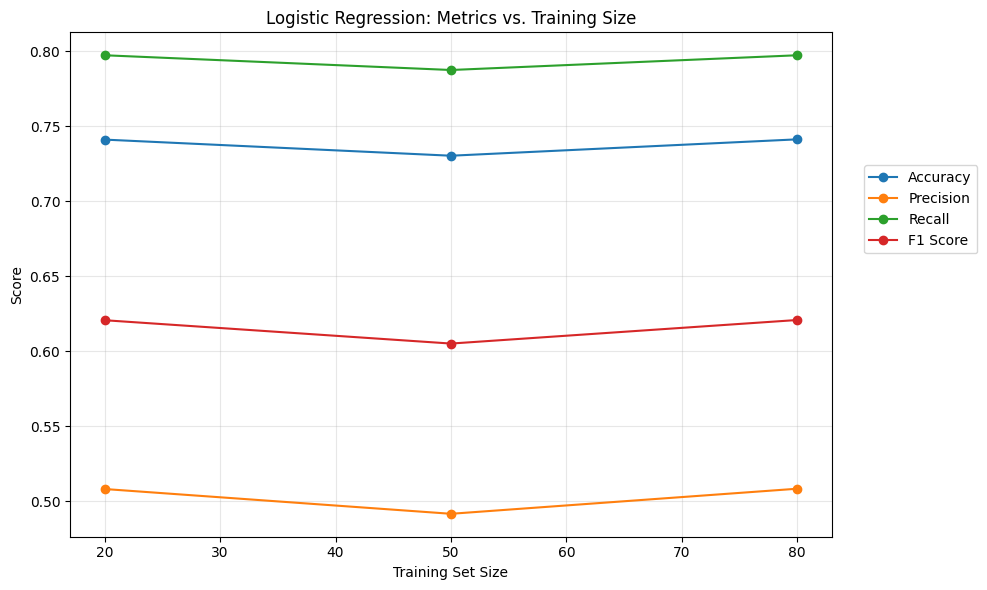

In [149]:
train_sizes = [20, 50, 80]
acc = [churn_logreg_20_cv['cv_mean_accuracy'],churn_logreg_50_cv['cv_mean_accuracy'], churn_logreg_80_cv['cv_mean_accuracy']]
prec = [churn_logreg_20_cv['cv_mean_precision'], churn_logreg_50_cv['cv_mean_precision'], churn_logreg_80_cv['cv_mean_precision']]
rec = [churn_logreg_20_cv['cv_mean_recall'], churn_logreg_50_cv['cv_mean_recall'], churn_logreg_80_cv['cv_mean_recall']]
f1 = [churn_logreg_20_cv['cv_mean_f1'], churn_logreg_50_cv['cv_mean_f1'], churn_logreg_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Logistic Regression: Metrics vs. Training Size")

#### SVM

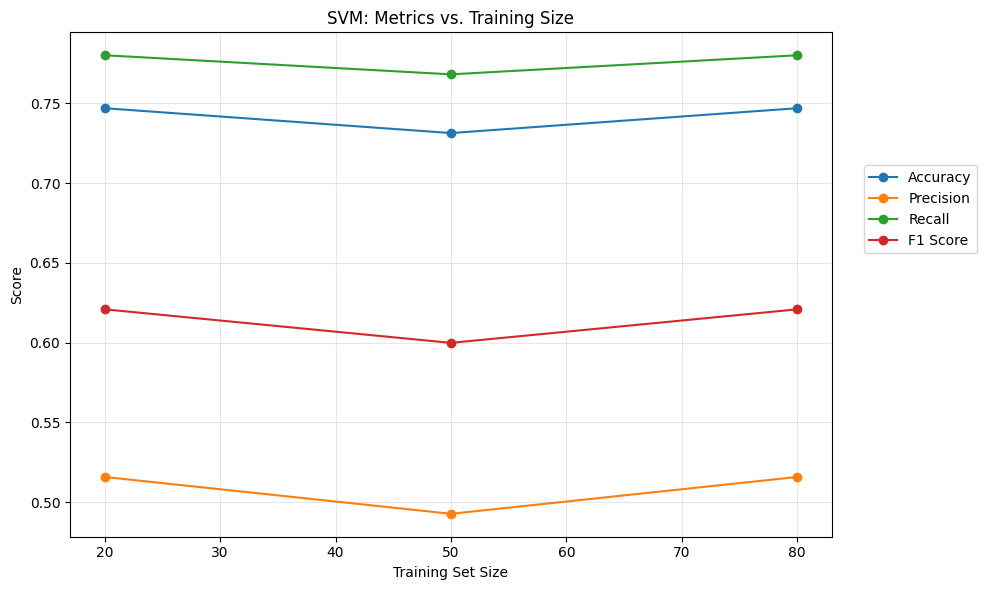

In [150]:
train_sizes = [20, 50, 80]
acc = [churn_svc_20_cv['cv_mean_accuracy'],churn_svc_50_cv['cv_mean_accuracy'], churn_svc_80_cv['cv_mean_accuracy']]
prec = [churn_svc_20_cv['cv_mean_precision'], churn_svc_50_cv['cv_mean_precision'], churn_svc_80_cv['cv_mean_precision']]
rec = [churn_svc_20_cv['cv_mean_recall'], churn_svc_50_cv['cv_mean_recall'], churn_svc_80_cv['cv_mean_recall']]
f1 = [churn_svc_20_cv['cv_mean_f1'], churn_svc_50_cv['cv_mean_f1'], churn_svc_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="SVM: Metrics vs. Training Size")

#### Decision Tree

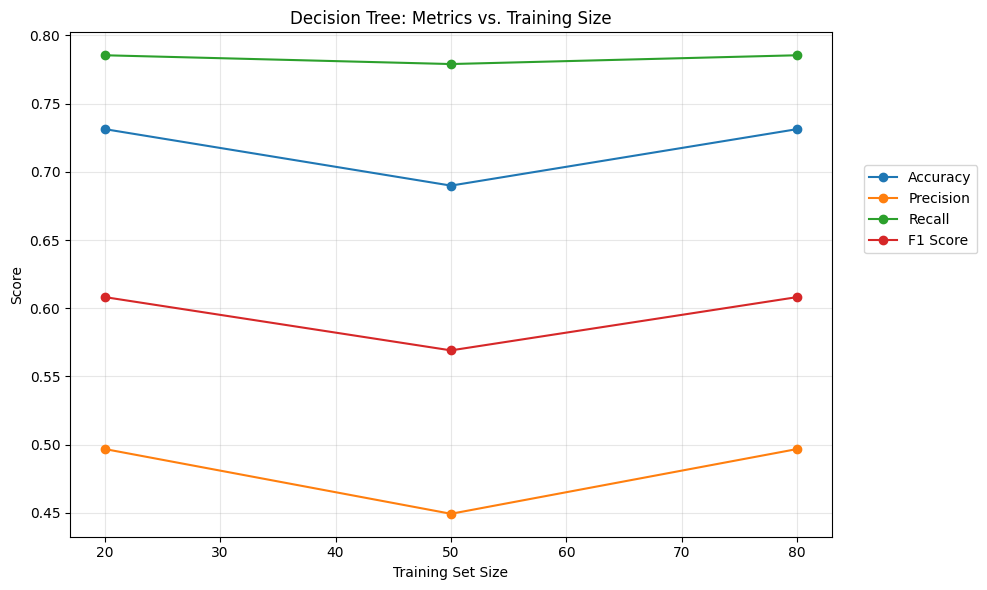

In [151]:
train_sizes = [20, 50, 80]
acc = [churn_dt_20_cv['cv_mean_accuracy'],churn_dt_50_cv['cv_mean_accuracy'], churn_dt_80_cv['cv_mean_accuracy']]
prec = [churn_dt_20_cv['cv_mean_precision'], churn_dt_50_cv['cv_mean_precision'], churn_dt_80_cv['cv_mean_precision']]
rec = [churn_dt_20_cv['cv_mean_recall'], churn_dt_50_cv['cv_mean_recall'], churn_dt_80_cv['cv_mean_recall']]
f1 = [churn_dt_20_cv['cv_mean_f1'], churn_dt_50_cv['cv_mean_f1'], churn_dt_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Decision Tree: Metrics vs. Training Size")

#### Random Forest

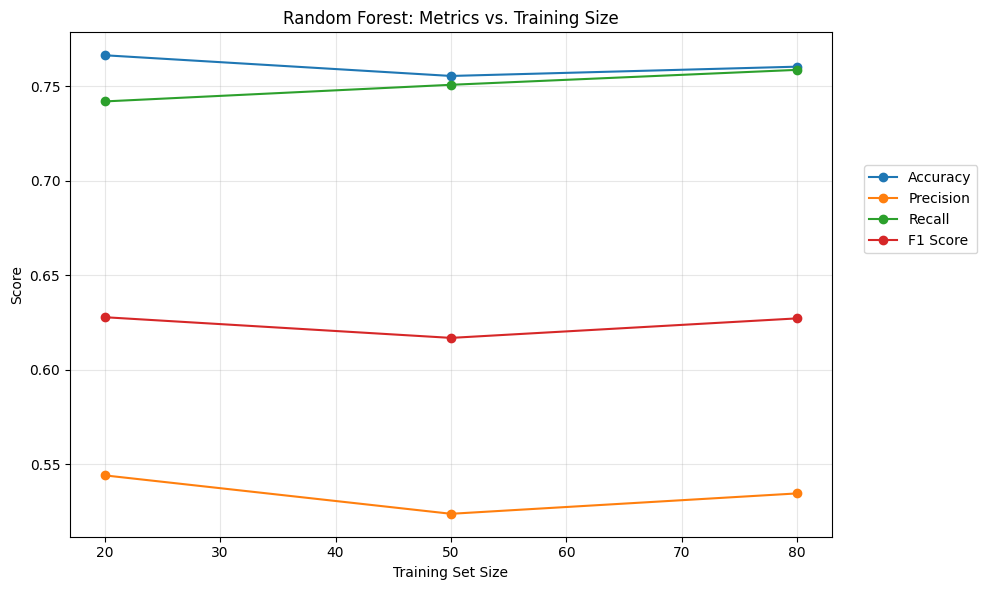

In [152]:
train_sizes = [20, 50, 80]
acc = [churn_rf_20_cv['cv_mean_accuracy'],churn_rf_50_cv['cv_mean_accuracy'], churn_rf_80_cv['cv_mean_accuracy']]
prec = [churn_rf_20_cv['cv_mean_precision'], churn_rf_50_cv['cv_mean_precision'], churn_rf_80_cv['cv_mean_precision']]
rec = [churn_rf_20_cv['cv_mean_recall'], churn_rf_50_cv['cv_mean_recall'], churn_rf_80_cv['cv_mean_recall']]
f1 = [churn_rf_20_cv['cv_mean_f1'], churn_rf_50_cv['cv_mean_f1'], churn_rf_80_cv['cv_mean_f1']]

plot_metrics_vs_training_size(train_sizes, acc, prec, rec, f1,
                              title="Random Forest: Metrics vs. Training Size")